In [1]:
import pandas as pd
import io
from PIL import Image

In [ ]:
# !git clone https://github.com/Sekkan-soluciones-biomedicas/FootSegmentation_4.git   # Clonamos el repositorio de archivos e imágenes.

Cloning into 'FootSegmentation_4'...
remote: Enumerating objects: 5831, done.
remote: Counting objects: 100% (1810/1810), done.
remote: Compressing objects: 100% (1651/1651), done.
remote: Total 5831 (delta 694), reused 332 (delta 144), pack-reused 4021 (from 1)
Receiving objects: 100% (5831/5831), 503.81 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (1887/1887), done.
Updating files: 100% (5334/5334), done.


In [ ]:
# !git clone https://github.com/uwm-bigdata/wound-segmentation.git

Cloning into 'wound-segmentation'...
remote: Enumerating objects: 3487, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3487 (delta 0), reused 1 (delta 0), pack-reused 3484 (from 1)
Receiving objects: 100% (3487/3487), 338.79 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (1248/1248), done.
Updating files: 100% (2593/2593), done.


## Apartado para agregar el nuevo dataset:

In [2]:
# prompt: Dame una función que tome como argumento una el path de una carpeta y me devuelva la cantidad de archivos dentro de la misma

import os

def count_files_in_folder(folder_path):

  if not os.path.isdir(folder_path):
    return 0  # O puedes lanzar una excepción si la ruta no es una carpeta válida
  file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

  # return print(f"La carpeta contiene {file_count} archivos.")
  return file_count

#### Juntamos el ds viejo y el nuevo completos en una nueva carpeta:

Creamos una carpeta ("*Ims_double*") con todas las imágenes (las del viejo DS y el nuevo DS) juntas, tanto para las imágenes como para las máscaras:

In [ ]:
# prompt: Dame una función que tome como argumento una lista de paths de carpetas, de tal forma que copie el contenido de todas las carpetas de la lista en una nueva carpeta la cual se debe crear (el path para esta última carpeta se pasará como un segundo argumento a la función)

import shutil
import os

def copy_folders_content(source_folders, destination_folder):
  """
  Copies the content of multiple source folders into a new destination folder.

  Args:
    source_folders: A list of paths to the source folders.
    destination_folder: The path to the new destination folder.-.,ma
  """

  if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

  for source_folder in source_folders:
    for item in os.listdir(source_folder):
      source_path = os.path.join(source_folder, item)
      destination_path = os.path.join(destination_folder, item)

      if os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
      else:
        shutil.copy2(source_path, destination_path)

# Example usage:
# source_folders = ["/path/to/folder1", "/path/to/folder2"]
# destination_folder = "/path/to/new_folder"
# copy_folders_content(source_folders, destination_folder)

**Juntamos las todas las imágenes tanto de test (o validation) como del training.**

(Se juntan las 1010 totales del DFU challenge junto con las 1010 de heridas en la piel)

$⇒ 2020$ imágenes totales con sus máscaras.

In [ ]:
# Juntamos las todas las imágenes.
copy_folders_content(["/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images", "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images"], "/content/FootSegmentation_4/images-unet/Ims_double/Imagenes")
# Juntamos las todas las máscaras.
copy_folders_content(["/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels", "/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels"], "/content/FootSegmentation_4/images-unet/Ims_double/Mascaras")

## Creamos las carpetas dentro de *Ims_double* necesarias para el dataloader del modelo (-Esto es lo que ya se tenía en el otro código-):

In [ ]:
import os
import numpy as np
from PIL import Image
import shutil

# Definir rutas
data_dir = './FootSegmentation_4/images-unet/Ims_double/'  # Dirección de la carpeta Ims_double.
images_dir = os.path.join(data_dir, 'Imagenes')
masks_dir = os.path.join(data_dir, 'Mascaras')

# Definir los porcentajes de división de los datos:
train_size_perc = 0.80
val_size_perc = 0.10
test_size_perc = 1.0 - (train_size_perc + val_size_perc)

# Crear nuevas carpetas para las divisiones
train_images_dir = os.path.join(data_dir, 'train_images')
train_masks_dir = os.path.join(data_dir, 'train_masks')
val_images_dir = os.path.join(data_dir, 'val_images')
val_masks_dir = os.path.join(data_dir, 'val_masks')
test_images_dir = os.path.join(data_dir, 'test_images')
test_masks_dir = os.path.join(data_dir, 'test_masks')

# Crear directorios si no existen
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

# Obtener todas las imágenes y máscaras
images = sorted(os.listdir(images_dir))  # Aseguramos que el orden sea consistente
masks = sorted(os.listdir(masks_dir))

# Verificamos que cada imagen tenga su máscara correspondiente
assert len(images) == len(masks), "El número de imágenes y máscaras no coincide"

# Asegurarse de que las imágenes y máscaras coinciden por nombre
# for img, mask in zip(images, masks):
    # assert img.split('.')[0] +'_mask' == mask.split('.')[0], f"Imagen y máscara no coinciden: {img} y {mask}"

# Mezclar datos aleatoriamente
indices = np.arange(len(images))
np.random.shuffle(indices)

# Calcular los tamaños de los conjuntos
train_size = int(train_size_perc * len(images))
val_size = int(val_size_perc * len(images))
test_size = len(images) - train_size - val_size



train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Función para copiar archivos
def copy_files(indices, src_images_dir, src_masks_dir, dest_images_dir, dest_masks_dir):
    for idx in indices:
        img_file = images[idx]
        mask_file = masks[idx]

        img_path = os.path.join(src_images_dir, img_file)
        mask_path = os.path.join(src_masks_dir, mask_file)

        shutil.copy(img_path, os.path.join(dest_images_dir, img_file))
        shutil.copy(mask_path, os.path.join(dest_masks_dir, mask_file))

# Copiar archivos a las carpetas correspondientes
copy_files(train_indices, images_dir, masks_dir, train_images_dir, train_masks_dir)
copy_files(val_indices, images_dir, masks_dir, val_images_dir, val_masks_dir)
copy_files(test_indices, images_dir, masks_dir, test_images_dir, test_masks_dir)

print("División de datos completada. Train_size: ", train_size, " . Val_size: ", val_size, " . Test_size: ", test_size )
print("Porcentajes: ",int(train_size_perc*100),'-',int(val_size_perc*100),'-',int(round(test_size_perc*100)))

División de datos completada. Train_size:  808  . Val_size:  101  . Test_size:  101
Porcentajes:  80 - 10 - 10


In [ ]:
count_files_in_folder("/content/FootSegmentation_4/images-unet/Ims_double/train_images"), count_files_in_folder("/content/FootSegmentation_4/images-unet/Ims_double/train_masks")

(808, 808)

In [ ]:
# prompt: Borra la carpeta /content/FootSegmentation_4/images-unet/Ims_double con todo su contenido

# # BORRAR CARPETA, cuidado!
# import shutil

# shutil.rmtree('/content/FootSegmentation_4/images-unet/Ims_double', ignore_errors=True)

# Definición del modelo:

In [ ]:
# Creamos la carpeta donde se guardan las predicciones durante el entrenamiento (Importante):
# !mkdir /content/saved_images/

`main.py` :

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torchvision.transforms.functional as TF

# class conv_block(nn.Module):
#     def __init__(self, in_c, out_c, act=True):
#         super().__init__()
#         layers = [nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)]
#         if act:
#             layers.append(nn.BatchNorm2d(out_c))
#             layers.append(nn.ReLU(inplace=True))
#         self.conv = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.conv(x)

# class encoder_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.c1 = nn.Sequential(
#             conv_block(in_c, out_c),
#             conv_block(out_c, out_c)
#         )
#         self.p1 = nn.MaxPool2d((2, 2))

#     def forward(self, x):
#         x = self.c1(x)
#         p = self.p1(x)
#         return x, p

# Bloque de código de cada capa de la Unet (donde se aplican las dos convoluciones, Además se aplica el btchnorm):
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# class unet3plus(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super().__init__()
#         """ Encoder """
#         self.e1 = encoder_block(in_channels, 64)
#         self.e2 = encoder_block(64, 128)
#         self.e3 = encoder_block(128, 256)
#         self.e4 = encoder_block(256, 512)

#         """ Bottleneck """
#         self.e5 = nn.Sequential(
#             conv_block(512, 1024),
#             conv_block(1024, 1024)
#         )

#         """ Decoders """
#         self.e1_d4 = conv_block(64, 64)
#         self.e2_d4 = conv_block(128, 64)
#         self.e3_d4 = conv_block(256, 64)
#         self.e4_d4 = conv_block(512, 64)
#         self.e5_d4 = conv_block(1024, 64)
#         self.d4 = conv_block(64 * 5, 64)

#         self.e1_d3 = conv_block(64, 64)
#         self.e2_d3 = conv_block(128, 64)
#         self.e3_d3 = conv_block(256, 64)
#         self.e4_d3 = conv_block(64, 64)
#         self.e5_d3 = conv_block(1024, 64)
#         self.d3 = conv_block(64 * 5, 64)

#         self.e1_d2 = conv_block(64, 64)
#         self.e2_d2 = conv_block(128, 64)
#         self.e3_d2 = conv_block(64, 64)
#         self.e4_d2 = conv_block(64, 64)
#         self.e5_d2 = conv_block(1024, 64)
#         self.d2 = conv_block(64 * 5, 64)

#         self.e1_d1 = conv_block(64, 64)
#         self.e2_d1 = conv_block(64, 64)
#         self.e3_d1 = conv_block(64, 64)
#         self.e4_d1 = conv_block(64, 64)
#         self.e5_d1 = conv_block(1024, 64)
#         self.d1 = conv_block(64 * 5, 64)

#         """ Output """
#         self.y1 = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, inputs):
#         e1, p1 = self.e1(inputs)
#         e2, p2 = self.e2(p1)
#         e3, p3 = self.e3(p2)
#         e4, p4 = self.e4(p3)

#         """ Bottleneck """
#         e5 = self.e5(p4)

#         """ Decoder 4 """
#         e1_d4 = F.max_pool2d(e1, kernel_size=8, stride=8)
#         e1_d4 = self.e1_d4(e1_d4)
#         e2_d4 = F.max_pool2d(e2, kernel_size=4, stride=4)
#         e2_d4 = self.e2_d4(e2_d4)
#         e3_d4 = F.max_pool2d(e3, kernel_size=2, stride=2)
#         e3_d4 = self.e3_d4(e3_d4)
#         e4_d4 = self.e4_d4(e4)
#         e5_d4 = F.interpolate(e5, scale_factor=2, mode="bilinear", align_corners=True)
#         e5_d4 = self.e5_d4(e5_d4)
#         d4 = torch.cat([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4], dim=1)
#         d4 = self.d4(d4)

#         """ Decoder 3 """
#         e1_d3 = F.max_pool2d(e1, kernel_size=4, stride=4)
#         e1_d3 = self.e1_d3(e1_d3)
#         e2_d3 = F.max_pool2d(e2, kernel_size=2, stride=2)
#         e2_d3 = self.e2_d3(e2_d3)
#         e3_d3 = self.e3_d3(e3)
#         e4_d3 = F.interpolate(d4, scale_factor=2, mode="bilinear", align_corners=True)
#         e4_d3 = self.e4_d3(e4_d3)
#         e5_d3 = F.interpolate(e5, scale_factor=4, mode="bilinear", align_corners=True)
#         e5_d3 = self.e5_d3(e5_d3)
#         d3 = torch.cat([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3], dim=1)
#         d3 = self.d3(d3)

#         """ Decoder 2 """
#         e1_d2 = F.max_pool2d(e1, kernel_size=2, stride=2)
#         e1_d2 = self.e1_d2(e1_d2)
#         e2_d2 = self.e2_d2(e2)
#         e3_d2 = F.interpolate(d3, scale_factor=2, mode="bilinear", align_corners=True)
#         e3_d2 = self.e3_d2(e3_d2)
#         e4_d2 = F.interpolate(d4, scale_factor=4, mode="bilinear", align_corners=True)
#         e4_d2 = self.e4_d2(e4_d2)
#         e5_d2 = F.interpolate(e5, scale_factor=8, mode="bilinear", align_corners=True)
#         e5_d2 = self.e5_d2(e5_d2)
#         d2 = torch.cat([e1_d2, e2_d2, e3_d2, e4_d2, e5_d2], dim=1)
#         d2 = self.d2(d2)

#         """ Decoder 1 """
#         e1_d1 = self.e1_d1(e1)
#         e2_d1 = F.interpolate(d2, scale_factor=2, mode="bilinear", align_corners=True)
#         e2_d1 = self.e2_d1(e2_d1)
#         e3_d1 = F.interpolate(d3, scale_factor=4, mode="bilinear", align_corners=True)
#         e3_d1 = self.e3_d1(e3_d1)
#         e4_d1 = F.interpolate(d4, scale_factor=8, mode="bilinear", align_corners=True)
#         e4_d1 = self.e4_d1(e4_d1)
#         e5_d1 = F.interpolate(e5, scale_factor=16, mode="bilinear", align_corners=True)
#         e5_d1 = self.e5_d1(e5_d1)
#         d1 = torch.cat([e1_d1, e2_d1, e3_d1, e4_d1, e5_d1], dim=1)
#         d1 = self.d1(d1)

#         """ Output """
#         y1 = self.y1(d1)
#         return y1

class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

        # Down part of Unet:
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of Unet:
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottlenech = DoubleConv(features[-1], features[-1]*2) # Medium part
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #Final part


    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottlenech(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 160, 160))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [4]:
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [ ]:
# import torch
# import torch.nn as nn
# import  torchvision.transforms.functional as TF

# # Bloque de código de cada capa de la Unet (donde se aplican las dos convoluciones, Además se aplica el btchnorm):
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class UNET(nn.Module):
#     def __init__(
#         self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
#     ):
#         super(UNET, self).__init__()
#         self.downs = nn.ModuleList()
#         self.ups = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

#         # Down part of Unet:
#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature

#         # Up part of Unet:
#         for feature in reversed(features):
#             self.ups.append(
#                 nn.ConvTranspose2d(
#                     feature*2, feature, kernel_size=2, stride=2,
#                 )
#             )
#             self.ups.append(DoubleConv(feature*2, feature))

#         self.bottlenech = DoubleConv(features[-1], features[-1]*2) # Medium part
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #Final part


#     def forward(self, x):
#         skip_connections = []
#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottlenech(x)
#         skip_connections = skip_connections[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](concat_skip)

#         return self.final_conv(x)

# def test():
#     x = torch.randn((3, 1, 161, 161))
#     model = UNET(in_channels=1, out_channels=1)
#     preds = model(x)
#     print(preds.shape)
#     print(x.shape)
#     assert preds.shape == x.shape

# # if __name__ == "__main__":
# #     test()

`dataset.py` :

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np


class MiccaiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform =  transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

`utils.py`:

In [6]:
import torch
import torchvision
# from dataset import MiccaiDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory = True,
):
    train_ds = MiccaiDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = MiccaiDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_dice_acc(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds =  (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += (torch.numel(preds))
            dice_score += (2* (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    accuracy = num_correct / num_pixels if num_pixels > 0 else 0 # Calculate accuracy
    print(
        f"Got {num_correct}/{num_pixels} with acc {accuracy*100:.3f}"
    )

    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    return dice_score/len(loader), accuracy

def save_predictions_as_imgs(
        loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        # torchvision.utils.save_image(y.unsqueeze(1), f"{folder}")  # para colab
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/target_{idx}.png")

    model.train()


## Otros:

def replace_backslashes(input_string):
  """Replaces all backslashes '\' in a string with forward slashes '/'."""
  return input_string.replace("\\", "/")
# ex: a = replace_backslashes(r"C:\Users\user\Documents\file.txt")

`train.py` :

In [7]:
from re import L
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


def dice_loss(input, target):
    smooth = 1.0
    input = torch.sigmoid(input)  # Aplicar sigmoide para obtener probabilidades
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))


# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
# NUM_EPOCHS = 83
NUM_WORKERS = 0
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = True

TRAIN_IMG_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/train_images"
TRAIN_MASK_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/train_masks"
VAL_IMG_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/val_images"
VAL_MASK_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/val_masks"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0  # Inicializar la pérdida total
    num_batches = 0  # Inicializar el contador de batches

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward:
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward:
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item)

        # Acumular la pérdida y contar los batches
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches

    return avg_loss  # Devolver la pérdida promedio


def main(NUM_EPOCHS=10):
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2()
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    # loss_fn = nn.BCEWithLogitsLoss()
    loss_fn = dice_loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5) # Reduce LR if validation loss plateaus

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY
    )

    # if LOAD_MODEL:
    #     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    scaler = torch.cuda.amp.GradScaler()
    L_dice = []
    L_loss = []
    L_accuracy = []
    best_dice_score = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch: {epoch + 1}")
        epoch_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        L_loss.append(epoch_loss)
        scheduler.step(epoch_loss) # Update scheduler based on training loss

        # Check accuracy on validation set
        dc, acc = check_dice_acc(val_loader, model, device=DEVICE)
        L_dice.append(dc)
        L_accuracy.append(acc)

        # Save best model, based in dice score.
        if dc > best_dice_score:
          best_dice_score = dc
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
          }
          # torch.save(checkpoint, f"model_checkpoint_epoch_{epoch+1}.pth")
          torch.save(checkpoint, "best_model_checkpoint.pth")

        # Save some example predictions to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )
    return model, L_dice, L_loss, L_accuracy

c:\Users\am969\anaconda3\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
DEVICE

device(type='cuda')

## Entrenamos el modelo:

In [10]:
model3, L_dice2, L_loss2, L_acc2 = main(NUM_EPOCHS = 10)

C:\Users\am969\AppData\Local\Temp\ipykernel_17844\3020276616.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch: 1


  0%|          | 0/202 [00:00<?, ?it/s]C:\Users\am969\AppData\Local\Temp\ipykernel_17844\3020276616.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 202/202 [01:06<00:00,  3.02it/s, loss=<built-in method item of Tensor object at 0x000002593CE1CBF0>]


Got 5448107/5817600 with acc 93.649
Dice score: 0.2645909786224365
Epoch: 2


100%|██████████| 202/202 [01:08<00:00,  2.95it/s, loss=<built-in method item of Tensor object at 0x000002593CE36570>]


Got 5608631/5817600 with acc 96.408
Dice score: 0.3926559090614319
Epoch: 3


100%|██████████| 202/202 [01:08<00:00,  2.94it/s, loss=<built-in method item of Tensor object at 0x000002593CE17EF0>]


Got 5643382/5817600 with acc 97.005
Dice score: 0.43999183177948
Epoch: 4


100%|██████████| 202/202 [00:57<00:00,  3.51it/s, loss=<built-in method item of Tensor object at 0x000002593CE36BD0>]


Got 5676056/5817600 with acc 97.567
Dice score: 0.4666043221950531
Epoch: 5


100%|██████████| 202/202 [00:47<00:00,  4.28it/s, loss=<built-in method item of Tensor object at 0x000002593CE1C290>]


Got 5758081/5817600 with acc 98.977
Dice score: 0.6294186115264893
Epoch: 6


100%|██████████| 202/202 [00:47<00:00,  4.29it/s, loss=<built-in method item of Tensor object at 0x000002593CE36750>]


Got 5775532/5817600 with acc 99.277
Dice score: 0.6715063452720642
Epoch: 7


100%|██████████| 202/202 [00:46<00:00,  4.33it/s, loss=<built-in method item of Tensor object at 0x000002593CDF48F0>]


Got 5778889/5817600 with acc 99.335
Dice score: 0.7226705551147461
Epoch: 8


100%|██████████| 202/202 [00:47<00:00,  4.25it/s, loss=<built-in method item of Tensor object at 0x000002593CE369F0>]


Got 5784168/5817600 with acc 99.425
Dice score: 0.7495802640914917
Epoch: 9


100%|██████████| 202/202 [00:47<00:00,  4.25it/s, loss=<built-in method item of Tensor object at 0x000002593CE1CC50>]


Got 5787020/5817600 with acc 99.474
Dice score: 0.773547351360321
Epoch: 10


100%|██████████| 202/202 [00:47<00:00,  4.30it/s, loss=<built-in method item of Tensor object at 0x000002593CE366F0>]


Got 5786035/5817600 with acc 99.457
Dice score: 0.7623968124389648


In [12]:
# prompt: carga el modelo con las mejores métricas (guardado en el archivo best_model_checkpoint.pth) asignándolo a la variable model2

import torch

# Assuming 'best_model_checkpoint.pth' is in the current working directory.
# If not, adjust the path accordingly.
checkpoint = torch.load("best_model_checkpoint.pth")

# Assuming UNET class is defined in the current scope
# If not, make sure the definition of UNET is available before this line

model2 = UNET(in_channels=3, out_channels=1).to(DEVICE)
model2.load_state_dict(checkpoint["state_dict"])
# model2.eval() #set to evaluation mode

C:\Users\am969\AppData\Local\Temp\ipykernel_17844\60604829.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_checkpoint.pth")


<All keys matched successfully>

In [13]:
# GUARDAR EL MODELO EN UN ZIP:
# prompt: Guarda en modelo model1 que acabo de entrenar en un archivo zip, para que después lo pueda cargar en otro script

import zipfile
import os

def save_model_to_zip(model, filename="model2.zip"):
  """Saves the trained PyTorch model to a zip file.

  Args:
    model: The trained PyTorch model.
    filename: The name of the zip file to save the model to.
  """
  # Save the model state dictionary
  torch.save(model.state_dict(), "model2_weights.pth")

  # Create a zip file containing the model weights
  with zipfile.ZipFile(filename, 'w') as zipf:
    zipf.write("model2_weights.pth")

  # Remove the temporary weights file
  os.remove("model2_weights.pth")


save_model_to_zip(model2)

# Hacer predicciones con el modelo:

In [14]:
# CARGAR EL MODELO DEL ZIP (solo para guardar este código):
# prompt: Ahora dame el código con el que lo cargaría en el otro script, asignándolo a la variable model2

import torch
# from model import UNET  # Assuming your UNET class is in a file named model.py
import zipfile

def load_model_from_zip(zip_filename, device="cpu"):
  """Loads a PyTorch model from a zip file.

  Args:
    zip_filename: The name of the zip file containing the model weights.
    device: The device to load the model onto (e.g., "cuda" or "cpu").

  Returns:
    The loaded PyTorch model.
  """

  with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extractall()

  model = UNET(in_channels=3, out_channels=1).to(device)
  model.load_state_dict(torch.load("model2_weights.pth", map_location=device))

  return model


# Example of how to load the model
model2 = load_model_from_zip("model2.zip", device=DEVICE)

C:\Users\am969\AppData\Local\Temp\ipykernel_17844\4039379968.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_weights.pth", map_

In [15]:
# prompt: Obtén el path de una imágen escogida aleatoriamente del folder /content/FootSegmentation_4/images-unet/IMs29Ago/test_images/

import os
import random

def get_random_image_path(folder_path):
  """
  Obtiene el path de una imagen escogida aleatoriamente del folder especificado.

  Args:
    folder_path: Ruta a la carpeta que contiene las imágenes.

  Returns:
    Path de la imagen aleatoria, o None si la carpeta está vacía.
  """
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
  if not image_files:
    return None
  random_image_file = random.choice(image_files)
  return os.path.join(folder_path, random_image_file)


# image_folder = "/content/FootSegmentation_4/images-unet/Ims_double/test_images"
image_folder = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images"

random_image_path = get_random_image_path(image_folder)

if random_image_path:
  print(f"Path de la imagen aleatoria: {random_image_path}")
else:
  print(f"La carpeta '{image_folder}' está vacía.")

Path de la imagen aleatoria: C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images\0744.png


In [16]:
# TOMA EL MODELO CARGADO EN LA CELDA ANETERIOR Y HACE UNA PREDICCIÓN:
# prompt: Ahora haz la predicción (y muéstrala) de una imagen de mi carpeta /content/FootSegmentation_4/images-unet/IMs29Ago/test_images      con el modelo que acabo de entrenar

# Assuming your model is named 'model' and is already loaded with the trained weights.
# You'll need to adjust the paths and file names as needed.

import torch
import torchvision
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the path to the image you want to predict
image_path = random_image_path  # Replace with your image path

# Load the image
image = np.array(Image.open(image_path).convert("RGB"))

# Apply the same transformations used during training
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

augmentations = val_transforms(image=image)
image = augmentations["image"]

# Move the image to the device (CPU or GPU)
image = image.unsqueeze(0).to(DEVICE)


# Make the prediction
with torch.no_grad():
  prediction = torch.sigmoid(model2(image))
  prediction = (prediction > 0.5).float()

# Resize the prediction to 512x512
prediction = torchvision.transforms.functional.resize(prediction, size=(512, 512))

# Save the prediction as an image
torchvision.utils.save_image(prediction, "predicted_mask2.png")

print("Prediction saved as 'predicted_mask2.png'")

Prediction saved as 'predicted_mask2.png'


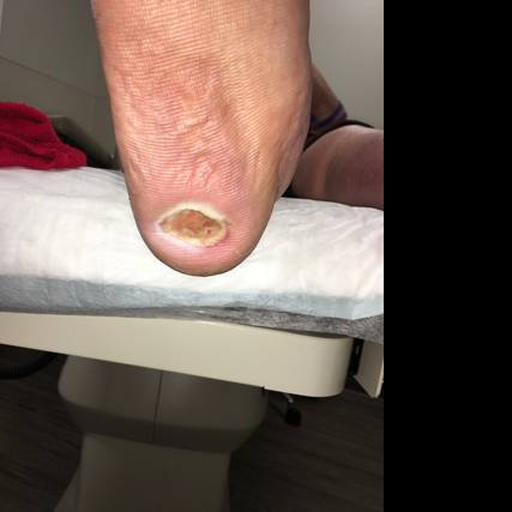

In [17]:
Image.open(random_image_path)

Guardamos las listas en un csv:

In [18]:
# prompt: Guarda las listas L_dice2, L_loss2, así como las epocas correspondientes en una primera columna en un csv

import pandas as pd

# Crear un DataFrame con las listas y las épocas
data = {'Epoch': range(1, len(L_dice2) + 1), 'Dice Score': [x.cpu().numpy() for x in L_dice2], 'Loss': L_loss2, 'Accuracy':[x.cpu().numpy() for x in L_acc2]}
# data = {'Epoch': range(1, len(L_dice2) + 1), 'Dice Score': L_dice2, 'Loss': L_loss2, 'Accuracy':L_acc2}
# data = {'Epoch': range(1, len(L_dice2) + 1), 'Dice Score': L_dice2, 'Loss': L_loss2, 'Accuracy':L_acc2}
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV
df.to_csv('metrics.csv', index=False)

# Gráficas de dice y loss funct. por cada época:

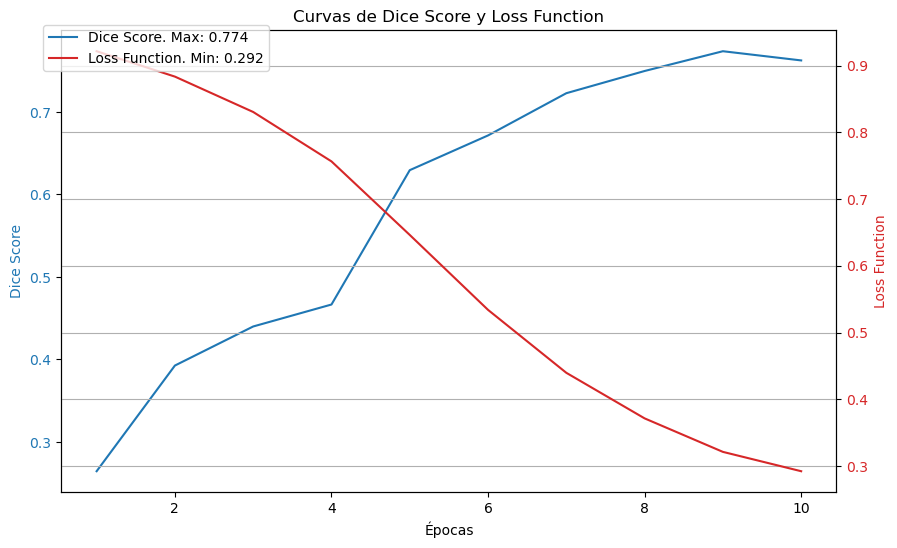

In [20]:
# prompt: Graficame [1,2,3] vs [4,5,6] en una gráfica elegante y bonita

import matplotlib.pyplot as plt


# Convert L_dice1 and L_loss1 to NumPy arrays
# L_dice1 = [x.cpu().numpy() for x in L_dice1] # Move tensors to CPU and convert to NumPy
L_dice2 = [x.cpu().numpy() for x in L_dice2]

# Datos de ejemplo (reemplaza con tus datos reales)
epochs = range(1, len(L_dice2) + 1)

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la curva de Dice Score
color = 'tab:blue'
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Dice Score', color=color)
ax1.plot(epochs, L_dice2, color=color, label=f'Dice Score. Max: {max(L_dice2):.3f}')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la Loss Function
ax2 = ax1.twinx()  # Compartir el eje x

color = 'tab:red'
ax2.set_ylabel('Loss Function', color=color)
ax2.plot(epochs, L_loss2, color=color, label=f'Loss Function. Min: {min(L_loss2):.3f}')
ax2.tick_params(axis='y', labelcolor=color)

# Agregar leyenda y título
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Curvas de Dice Score y Loss Function')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Métricas con el test set:

In [35]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import os

def get_test_loader(test_image_dir, test_mask_dir, batch_size=BATCH_SIZE, image_height=240, image_width=240, num_workers=0, pin_memory=True):
    val_transforms = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )

    test_ds = MiccaiDataset(
        image_dir=test_image_dir,
        mask_dir=test_mask_dir,
        transform=val_transforms,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return test_loader

def calculate_metrics(test_image_dir, test_mask_dir, model, device=DEVICE, image_height=240, image_width=240, num_workers=0, batch_size=BATCH_SIZE, pin_memory=True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    loader = get_test_loader(test_image_dir, test_mask_dir, batch_size= batch_size,  image_height=image_height, image_width=image_width, num_workers=num_workers, pin_memory=pin_memory)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    accuracy = num_correct / num_pixels if num_pixels > 0 else 0
    dice_coefficient = dice_score / len(loader) if len(loader) > 0 else 0

    model.train() # regresarlo a su estado original si se quiere seguir entrenando el modelo.

    return accuracy, dice_coefficient



# Calculamos las métricas del test set:
test_image_dir = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images"
test_mask_dir = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_masks"
batch_size = 4

# test_loader = get_test_loader(test_image_dir, test_mask_dir, batch_size)
# accuracy, dice_coefficient = calculate_metrics(test_loader, model2, device=DEVICE)
accuracy, dice_coefficient = calculate_metrics(test_image_dir, test_mask_dir, model2, device=DEVICE, image_height=240, image_width=240)
print(f"Accuracy: {accuracy:.4f}")
print(f"Dice Coefficient: {dice_coefficient:.4f}")

Accuracy: 0.9945
Dice Coefficient: 0.7535


In [27]:
# Best metrics:
print(f"Best_dice: {max(L_dice2):.4f}")
print(f"Best_accuracy: {max(L_acc2):.4f}")
print(f"Best_loss: {min(L_loss2):.4f}")
print(f"Best_epoch: {L_dice2.index(max(L_dice2))+1}")

Best_dice: 0.7735
Best_accuracy: 0.9947
Best_loss: 0.2925
Best_epoch: 9


In [31]:
batch_size = 4

test_loader = get_test_loader(VAL_IMG_DIR, VAL_MASK_DIR, batch_size)
accuracy, dice_coefficient = calculate_metrics(test_loader, model2, device=DEVICE)
print(f"Accuracy: {accuracy:.4f}")
print(f"Dice Coefficient: {dice_coefficient:.4f}")

Accuracy: 0.9948
Dice Coefficient: 0.7758
